We want to create an initial set of template waveforms, one template being a three-component seismogram.

This is what we want to keep in mind to have for all three channels:
- Windows with both P- and S- pick
- Only one earthquake in the window
- Raw SNR > 2 for P-wave
- Raw SNR > 3 for S-wave
- Prioritize higher magnitudes first

In [2]:
import obspy
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import time; import datetime
from obspy.core.utcdatetime import UTCDateTime
from obspy.clients.fdsn.client import Client

In [3]:
def read_files(base_folder):
    ''' Reads in earthquake catalog files from CSS format into useful pandas dataframes
    
        Inputs:
        base_folder = string containing name of year and month of interest, e.g. '2019_01'
        
        Outputs dataframes:
        assoc
        arrivals
        origin
    '''
    
    
    base_dir = 'catalog_css/'+base_folder+'/'
    
    arr_files = glob.glob(base_dir + 'catalog_XO_*arrival')
    assoc_files = glob.glob(base_dir + 'catalog_XO_*assoc')
    origin_files = glob.glob(base_dir + 'catalog_XO_*origin')
    
    # Read data into pandas dataframe
    arrivals = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in arr_files])
    assoc = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in assoc_files])
    origin = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in origin_files])

    # Rename some columns for clarity:
    assoc=assoc.rename(columns={0: "arrivalid", 1: "originid",2:"stationcode",3:"phase"})
    origin = origin.rename(columns={4:'originid',3:'epochtime',20:'magnitude'})
    arrivals=arrivals.rename(columns={2: "arrivalid", 6: "channel",0:"stationcode", 1:'epochtime',7:'phase'})
    
    return(assoc,arrivals,origin)

AK.CNP..BHZ | 2018-08-25T22:29:48.088400Z - 2018-08-25T22:49:48.068400Z | 50.0 Hz, 60000 samples


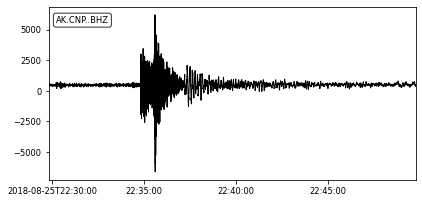

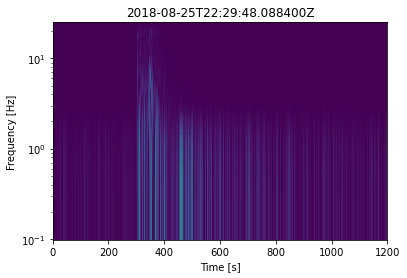

48.5781027596


Press Enter to continue... 


AK.CNP..BHN | 2018-08-25T22:30:33.088400Z - 2018-08-25T22:50:33.068400Z | 50.0 Hz, 60000 samples


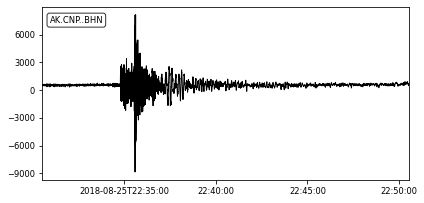

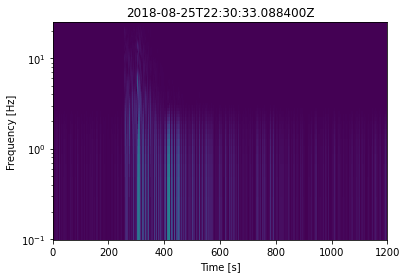

5.56305370388


Press Enter to continue... 


AK.SII..BHN | 2018-08-25T22:30:06.088400Z - 2018-08-25T22:50:06.068400Z | 50.0 Hz, 60000 samples


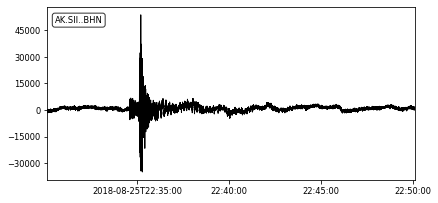

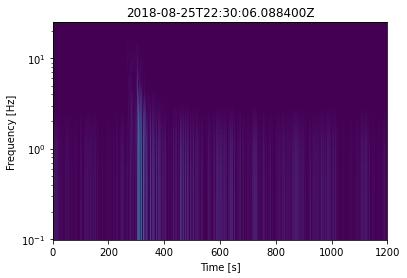

14.6270636462


Press Enter to continue... 


AK.SII..BHZ | 2018-08-25T22:29:33.088400Z - 2018-08-25T22:49:33.068400Z | 50.0 Hz, 60000 samples


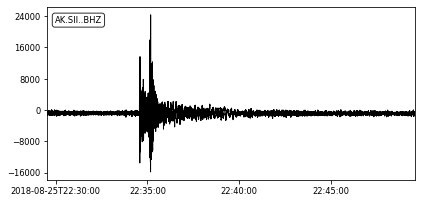

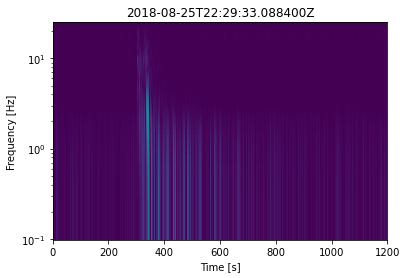

53.9418389291


Press Enter to continue... 


AK.CNP..BHZ | 2018-08-10T17:13:27.088400Z - 2018-08-10T17:33:27.068400Z | 50.0 Hz, 60000 samples


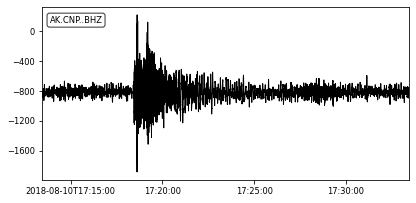

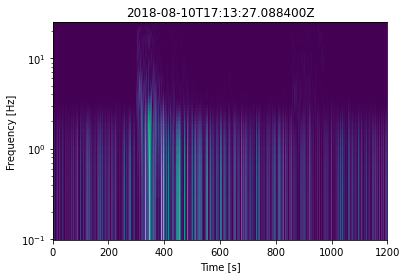

31.3430058243


In [ ]:
# Load catalog info for one month
month = '2018_08'
(assoc,arrivals,origin) = read_files(month)

# Sort events by magnitude, descending
origin = origin.sort_values(by=['magnitude'],ascending=False)
origin_ids = origin['originid']

# Loop through events
for id in origin_ids:

    # Get arrivals associated with this earthquake
    subset = assoc.loc[assoc['originid']==id]
    arrival_subset = arrivals.iloc[subset['arrivalid']-1]
    arrival_subset.reset_index(drop=True,inplace=True)
    
    # Get station names
    stations = arrival_subset['stationcode']

    # Get list of stations that have both P and S pick
    repeats = []
    for station in stations:
        sub = arrival_subset.loc[(arrival_subset['stationcode']==station)]
        if len(np.unique(sub['phase']))>1:
            repeats.append(station)

    repeat_subset = arrival_subset.loc[(arrival_subset['stationcode'].isin(repeats))]
    repeat_subset = repeat_subset.sort_values(by=['stationcode'])
    repeat_subset.reset_index(drop=True,inplace=True)
    # print(repeat_subset)

    
    # Loop through picks
    for i in range(0,len(repeat_subset)):
        pick = repeat_subset.iloc[i]
        
        # Skip global array stations that have low sample rates and complicated location codes
        if len(pick['stationcode'])>3:
            continue
            
        # P arrival time:
        pick_epoch = pick['epochtime']
        basetime = datetime.datetime.utcfromtimestamp(pick_epoch).strftime('%Y-%m-%dT%H:%M:%S.%m')

        
        # We want the streams for 20 minutes before and after the pick time:
        t1 = UTCDateTime(basetime)-datetime.timedelta(minutes = 5)
        t2 = UTCDateTime(basetime)+datetime.timedelta(minutes = 15)

        # Now we query the data from IRIS for each of the stations 20 min before and after the origin time, and add it to the master stream:
        client = Client("IRIS")

        # Download the streams INCLUDING the instrument response:
        st = client.get_waveforms("XO,AK",pick['stationcode'], "--",pick['channel'], t1, t2,attach_response=True)
        print(st[0])
        # Plot the raw waveform:
        %matplotlib inline
        fig = plt.figure()
        st.plot(fig = fig)                                      
        # plt.axvline(x=basetime,linewidth=2, color='r')
        plt.show()
        st.spectrogram(log=True, title=str(st[0].stats.starttime))
        
        # Calculate SNR of arrival
        data = st[0].data
        sr = int(st[0].stats.sampling_rate)
        psampleind = ((5*60)*sr)-1
        snr_num = max(abs(data[psampleind:(psampleind+(2*sr))]))
        snr_denom = np.std(data[(psampleind-(10*sr)):psampleind])
        snr = snr_num/snr_denom
        print(snr)


        input("Press Enter to continue...")